# Installing Dependencies

In [1]:
pip_list = !pip list
packages = ["chardet", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "spacy", "statsmodels", "tensorflow"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


# Importing Libraries

In [2]:
import calendar
import datetime
import os
import random
import shutil
import warnings
from io import BytesIO
from pickle import dump
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import chardet
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from PIL import Image
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib


%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1412888336076042316
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16149905408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17929172823618737412
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
0
MemTotal:       16390828 kB
0
Thu Jun  8 23:40:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. 

# Reading Data

In [5]:
df = pd.read_csv(
    data.csv,
    thousands=",",
    na_values="",
)
display(df)


,Unnamed: 0,tweet_text,disaster,type_of_disaster
0,0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,0.00,not disaster
1,1,RT @Jack4Ward: Get in on the fun every Thursda...,0.00,not disaster
2,2,Welcome to our newest STUDENTathlete- Reagan B...,0.00,not disaster
3,3,Denver Post: #Colorado governor signs bill cre...,0.00,not disaster
4,4,Pretty sure I'm going to live in Manitou Sprin...,0.00,not disaster
...,...,...,...,...
279646,283874,Bahamians rescued victims of Hurricane Dorian ...,1.00,hurricane
279647,283875,"""Bahamians rescued victims of Hurricane Dorian...",1.00,hurricane
279648,283876,Hurricane Dorian ravaged Bahamas cries for int...,1.00,hurricane
279649,283877,Bahamians rescue victims of Hurricane Dorian w...,1.00,hurricane


# Defining Parameters

In [6]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
MAX_TRIALS = 20
DUPLICATES = 0
SCALER = 1
NUM_BINS = 30
DATA_BALANCE = 1
SAMPLE_SIZE = 4_000
PRETRAINED_MODEL = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "roberta-base",
    "xlnet-base-cased",
    "albert-base-v2",
    "google/electra-base-discriminator"
][0]
NLP = 0
CLASSIFICATION = 1
EPOCHS = 50 if NLP else 10

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))
x_label = "tweet_text"
y_label = "disaster"


-------------------------------------------------------
Current Shape: (279651, 4).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (279651, 4).


,Unnamed: 0,tweet_text,disaster,type_of_disaster
24868,24868,wow really looks like a hurricane out there,1.00,hurricane
109462,109462,"but on a serious note, who's having the hurric...",1.00,hurricane
144026,144026,"during hurricanes harvey and irma, radio stati...",1.00,hurricane


# Mapping Target Values

In [7]:
df.dropna(subset=[y_label], axis=0, inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
df[y_label], y_index = df[y_label].factorize()
print(f"y_index: {[[i, y] for i, y in enumerate(y_index)]}")
display(df[y_label].value_counts().to_frame().rename({y_label: "Count"}, axis=1))


-------------------------------------------------------
Dropping null target values.
Current Shape: (279651, 4).
-------------------------------------------------------
y_index: [[0, 0.0], [1, 1.0]]


,Count
1,164261
0,115390


# Correlation Matrix

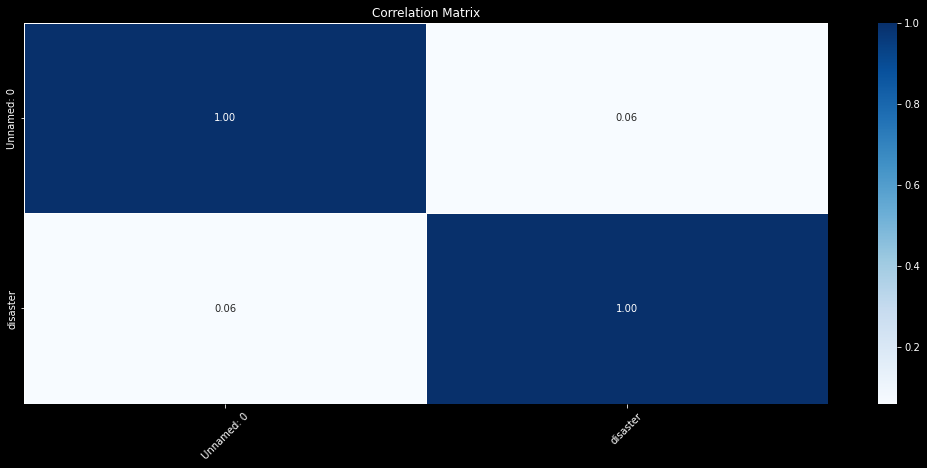

In [8]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()


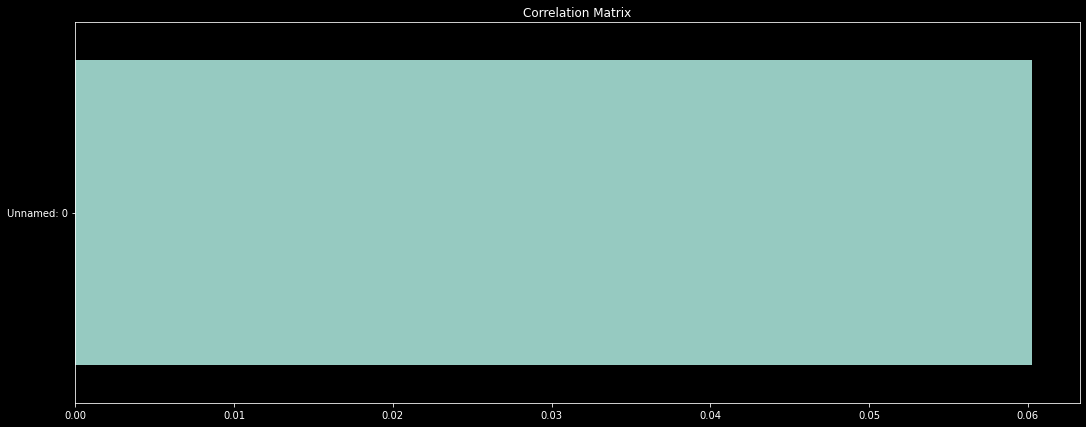

In [9]:
corr_matrix = df.corr()[y_label].sort_values().drop(y_label)
if corr_matrix.shape[0]:
    sns.barplot(x=corr_matrix.values, y=corr_matrix.index).set_title(
        "Correlation Matrix"
    )
    plt.show()


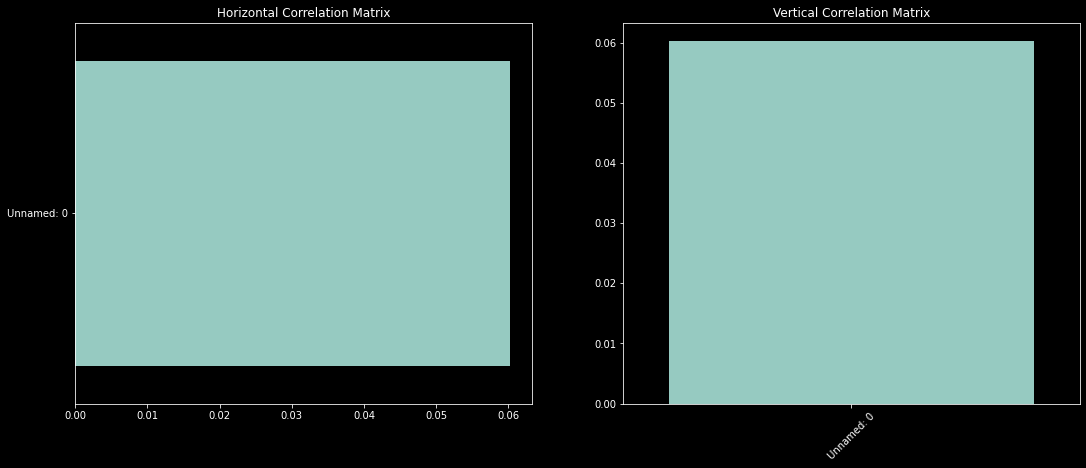

In [10]:
corr_matrix = df.corr()[y_label].abs().sort_values(ascending=False).drop(y_label)
if corr_matrix.shape[0]:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.barplot(x=corr_matrix.values, y=corr_matrix.index, ax=ax[0]).set_title(
        "Horizontal Correlation Matrix"
    )
    sns.barplot(x=corr_matrix.index, y=corr_matrix.values, ax=ax[1]).set_title(
        "Vertical Correlation Matrix"
    )
    plt.xticks(rotation=45)
    plt.show()


# Eliminating Multicollinearity between Features

In [11]:
def correlation(X, threshold):
    col_corr = set()
    df_corr = X.corr().abs()
    for i, _ in enumerate(df_corr.columns):
        for j in range(i):
            if (df_corr.iloc[i, j] >= threshold) and (
                df_corr.columns[j] not in col_corr
            ):
                col_corr.add(df_corr.columns[i])
    return col_corr


col_drop = correlation(df.drop(y_label, axis=1), 0.85)
df.drop(col_drop, inplace=True, axis=1)
print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Highly correlated cols have been removed: {len(col_drop)}.")
print(f"Highly correlated cols: {col_drop}.")


-------------------------------------------------------
Current Shape: (279651, 4).
-------------------------------------------------------
Highly correlated cols have been removed: 0.
Highly correlated cols: set().


# Checking NULL Values

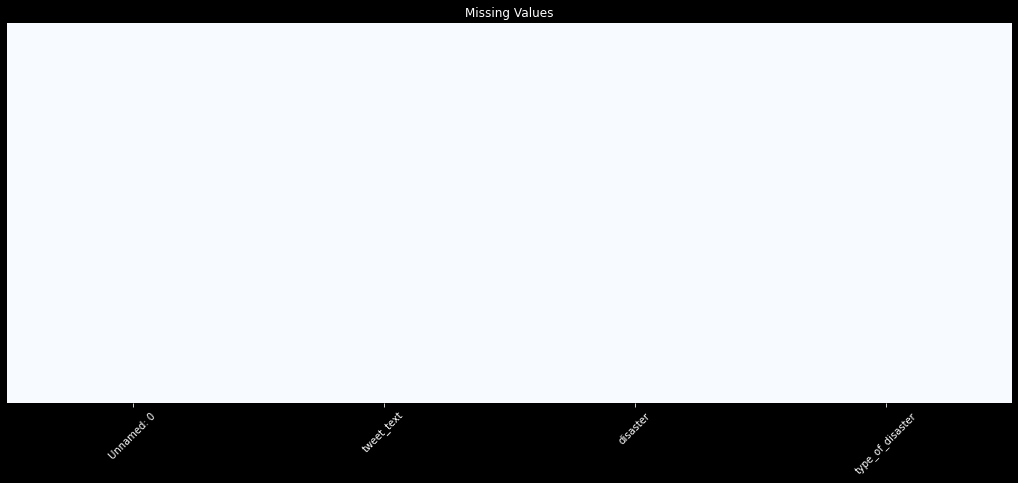

In [12]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")
plt.title("Missing Values")
plt.xticks(rotation=45)
plt.show()


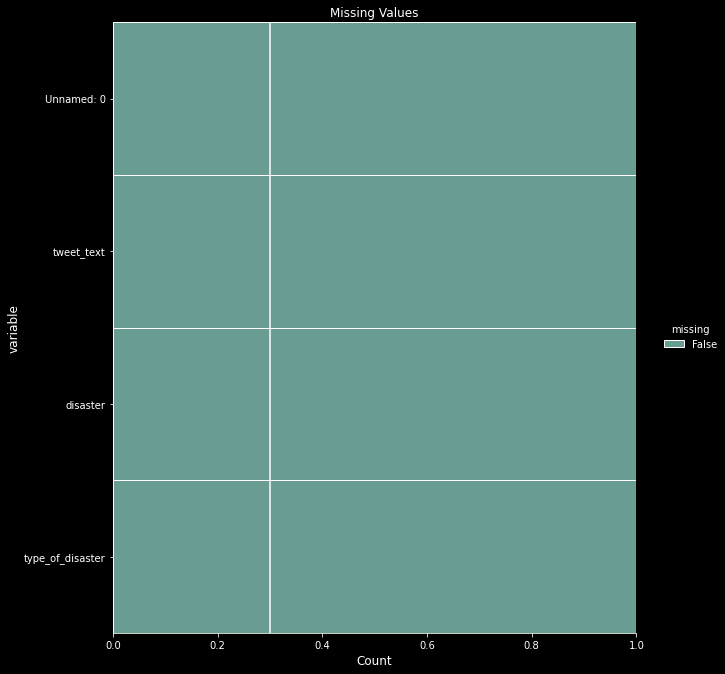

In [13]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()


# Data Wrangling

In [14]:
df.dropna(subset=[x_label], axis=0, inplace=True)
df.drop(["Unnamed: 0", "type_of_disaster"], axis=1, inplace=True)


# Feature Description

In [15]:
col_cat_cv = [x_label]
col_cat_oe = []
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="constant", fill_value="missing")),
    (OrdinalEncoder(categories=[["", ""]])),
)
col_cat = [
    col
    for col in df.columns
    if np.issubsctype(df[col].dtype, np.object0)
    and col != y_label
    and col not in col_cat_cv
]
col_num = [
    col
    for col in df.columns
    if np.issubsctype(df[col].dtype, np.number) and col != y_label
]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe + col_cat_cv]
col_num_disc = [col for col in col_num if df[col].nunique() <= 10]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [
            f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%"
            for col in df.columns
        ],
        "outliers": [
            f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}"
            if col in col_num
            else "n/a"
            for col in df.columns
        ],
        "outliers %": [
            f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%"
            if col in col_num
            else "n/a"
            for col in df.columns
        ],
        "kurtosis": [
            f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a"
            for col in df.columns
        ],
        "skewness": [
            f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a"
            for col in df.columns
        ],
        "corr": [
            f"{round(df[col].corr(other=df[y_label]) * 100)}%"
            if col in col_num
            else "n/a"
            for col in df.columns
        ],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [
            sorted(df[col].unique()) if col in col_num else df[col].unique()
            for col in df.columns
        ],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_cat_cv ({len(col_cat_cv)}): {col_cat_cv}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(
    f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_cat_cv) + len(col_num_disc) + len(col_num_cont)}"
)


,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
0,tweet_text,object,0,0%,n/a,n/a,n/a,n/a,n/a,233122,[#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA ...
1,disaster,int64,0,0%,n/a,n/a,n/a,n/a,n/a,2,"[0, 1]"


Current Shape: (279651, 2).
-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (0): []
col_cat_cv (1): ['tweet_text']
col_num_disc (0): []
col_num_cont (0): []
-------------------------------------------------------
total cols for preprocessor: 1


# Frequency Encoding (http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)

In [16]:
for col in col_cat_ohe:
    sr_temp = df.groupby(col)[y_label].count() / df.shape[0]
    df_temp = sr_temp[sr_temp > 0.01].index
    df[col] = np.where(df[col].isin(df_temp), df[col], "-")


# Count Encoding (http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)

In [17]:
MAX_COLS = 100
for col in col_cat_ohe:
    indice = df[col].value_counts()[:MAX_COLS].index
    df_temp = df[col].map(lambda value: value if value in indice else "-")
    # df[col] = df_temp
    print(df_temp.value_counts())
    print(f"unique values: {df_temp.nunique()}")
    print("-------------------------------------------------------")
try:
    display(df.describe(exclude="number").T.style.background_gradient(cmap="Blues"))
except Exception:
    pass


,count,unique,top,freq
tweet_text,279651,233122,Bald eagle rescued from car grill after Matthew passes: In the aftermath of Hurricane Matthew's path through ... http://cnn.it/2dWuUob,142


# Countplot for Categorical Feature(s)

In [18]:
for col in col_cat:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.countplot(
        x=df[col], ax=ax[0], hue=df[y_label] if CLASSIFICATION else None
    ).set_xlabel(f"{col}")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    ax[1].pie(
        x=df[col].value_counts(),
        autopct="%.1f%%",
        shadow=True,
        labels=df[col].value_counts().index,
    )
    ax[1].set_title(col)
plt.show()


# Distplot for Discrete Numeric Feature(s)

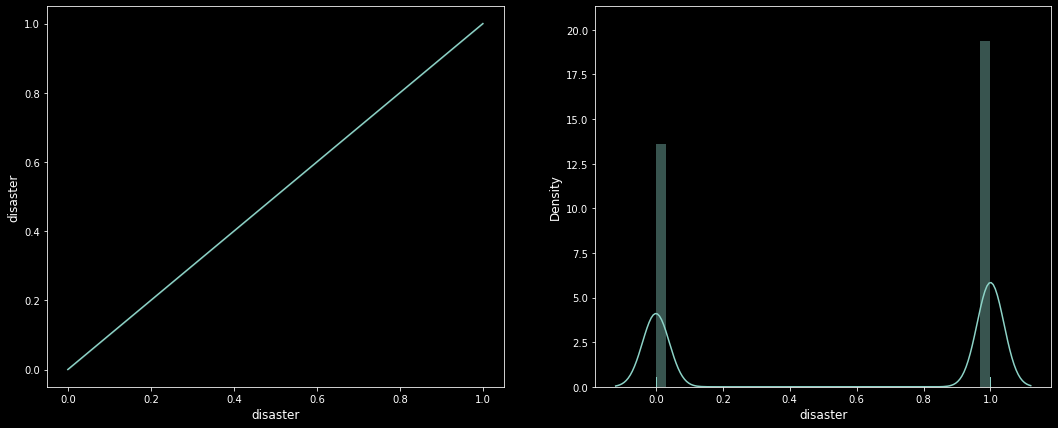

In [19]:
for col in col_num_disc + ([y_label] if CLASSIFICATION else []):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.lineplot(x=df[col], y=df[y_label], ax=ax[0]).set_xlabel(f"{col}")
    sns.distplot(x=df[col], ax=ax[1], rug=True).set_xlabel(f"{col}")
plt.show()


# Detecting Outliers

In [20]:
transformation_table = {
    "log": [],
    "log1p": [],
    "reciprocal": [],
    "sqrt": [],
    "exp": [],
    "boxcox": [],
    "boxcox1": [],
    "cap": [],
    "drop": [],
    "keep": df.columns.tolist(),
}
for transform, cols in transformation_table.items():
    if cols:
        col_outlier = [
            col
            for col in col_num_cont + ([] if CLASSIFICATION else [y_label])
            if col in cols
        ]
        q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
        iqr = q3 - q1
        lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
        condition = ~(
            (df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)
        ).any(axis=1)
        print("-------------------------------------------------------")
        print(f"Performing {transform} transformation on cols {cols}.")
        print(f"Current Shape: {df.shape}.")
        print("-------------------------------------------------------")
        print(f"Scanning for outliers in {col_outlier}.")
        print(
            f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%"
        )
        print("-------------------------------------------------------")
        print(f"upper_range:\n{upper_range}")
        print("-------------------------------------------------------")
        print(f"lower_range:\n{lower_range}")
        print("-------------------------------------------------------")
        if transform == "keep":
            print(f"Outliers have been kept {df.shape}.")
        elif transform == "cap":
            for col in col_outlier:
                df[col] = np.where(
                    df[col] < lower_range[col], lower_range[col], df[col]
                )
                df[col] = np.where(
                    df[col] > upper_range[col], upper_range[col], df[col]
                )
            print(f"Outliers have been capped {df.shape}.")
        elif transform == "drop":
            df = df[condition]
            print(f"Outliers have been removed {df.shape}.")
        elif transform == "log":
            for col in col_outlier:
                df[col] = np.log(df[col])
            print(f"Outliers have been log transformed {df.shape}.")
        elif transform == "log1p":
            for col in col_outlier:
                df[col] = np.log1p(df[col])
            print(f"Outliers have been log1p transformed {df.shape}.")
        elif transform == "reciprocal":
            for col in col_outlier:
                df[col] = 1 / df[col]
            print(f"Outliers have been reciprocal transformed {df.shape}.")
        elif transform == "sqrt":
            for col in col_outlier:
                df[col] = df[col] ** 0.5
            print(f"Outliers have been sqrt transformed {df.shape}.")
        elif transform == "exp":
            for col in col_outlier:
                df[col] = df[col] ** (1 / 1.2)
            print(f"Outliers have been exp transformed {df.shape}.")
        elif transform == "boxcox":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col])[0]
            print(f"Outliers have been boxcox transformed {df.shape}.")
        elif transform == "boxcox1":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col] + 1)[0]
            print(f"Outliers have been boxcox1 transformed {df.shape}.")
        print("\n\n")


-------------------------------------------------------
Performing keep transformation on cols ['tweet_text', 'disaster'].
Current Shape: (279651, 2).
-------------------------------------------------------
Scanning for outliers in [].
Outliers Percentage: 0.00%
-------------------------------------------------------
upper_range:
Series([], dtype: float64)
-------------------------------------------------------
lower_range:
Series([], dtype: float64)
-------------------------------------------------------
Outliers have been kept (279651, 2).





# Distplot, Boxplot and QQplot for Analysing Statistical Distribution of Each Feature

In [21]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.distplot(x=df[col], ax=ax[0], rug=True).set_xlabel(f"{col}")
    sns.boxplot(x=df[col], ax=ax[1], notch=True).set_xlabel(f"{col}")
    sm.qqplot(data=df[col], ax=ax[2], xlabel=col, ylabel="")
    ax[0].axvline(x=df[col].mean(), linestyle="--")
    ax[0].axvline(x=df[col].median(), linestyle="--")
    print("-------------------------------------------------------")
    print(
        f"{col}\nSkew: {df[col].skew(axis=0, skipna=True):.2f}\nKurtosis: {df[col].kurtosis(axis=0, skipna=True):.2f}"
    )
    plt.show()


# Statistical Analysis: Data Transformation to the Gaussian Distribution

In [22]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    for trans in [
        "keep",
        "log",
        "log1p",
        "reciprocal",
        "sqrt",
        "exp",
        "boxcox",
        "boxcox1",
    ]:
        lamb = 0
        try:
            fig, ax = plt.subplots(nrows=1, ncols=3)
            if trans == "keep":
                x = df[col]
            elif trans == "log":
                x = np.log(df[col])
            elif trans == "log1p":
                x = np.log1p(df[col])
            elif trans == "reciprocal":
                x = 1 / df[col]
            elif trans == "sqrt":
                x = df[col] ** 0.5
            elif trans == "exp":
                x = df[col] ** (1 / 1.2)
            elif trans == "boxcox":
                val, lamb = stat.boxcox(df[col])
                x = pd.Series(val, name=col)
            else:
                val, lamb = stat.boxcox(df[col] + 1)
                x = pd.Series(val, name=col)
            sns.distplot(x=x, ax=ax[0], rug=True).set_xlabel(f"{col}")
            sns.boxplot(x=x, ax=ax[1], notch=True).set_xlabel(f"{col}")
            sm.qqplot(data=x, ax=ax[2], xlabel=col, ylabel="")
            ax[0].axvline(x=x.mean(), linestyle="--")
            ax[0].axvline(x=x.median(), linestyle="--")
        except Exception:
            pass
        finally:
            for i in range(3):
                ax[i].set_title(f"{trans.title()} Transformation")
            print("-------------------------------------------------------")
            print(
                f"{col} {trans.title()} Transformation\nSkew: {x.skew(axis=0, skipna=True):.2f}\nKurtosis: {x.kurtosis(axis=0, skipna=True):.2f}\nlambda: {lamb}"
            )
            plt.show()


# Boxplot for Numeric Feature(s)

In [23]:
if col_num_cont:
    plt.title("Boxplots for Numeric Columns")
    sns.boxplot(data=df[[col for col in col_num_cont]], orient="h", notch=True)
    plt.show()


# Standard Distribution and Interquantile Range

In [24]:
display(df.describe().T.style.background_gradient(cmap="Blues").format("{:.2f}"))
display(
    df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues").format("{:.2f}")
)


,count,mean,std,min,25%,50%,75%,max
disaster,279651.00,0.59,0.49,0.00,0.00,1.00,1.00,1.00


,0.01,0.99
disaster,0.00,1.00


# Applying Transformation

In [25]:
transformation_table = {
    "log": [],
    "log1p": [],
    "reciprocal": [],
    "sqrt": [],
    "exp": [],
    "boxcox": [],
    "boxcox1": [],
    "cap": [],
    "drop": [],
    "keep": df.columns.tolist(),
}
for transform, cols in transformation_table.items():
    if cols:
        col_outlier = [
            col
            for col in col_num_cont + ([] if CLASSIFICATION else [y_label])
            if col in cols
        ]
        q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
        iqr = q3 - q1
        lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
        condition = ~(
            (df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)
        ).any(axis=1)
        print("-------------------------------------------------------")
        print(f"Performing {transform} transformation on cols {cols}.")
        print(f"Current Shape: {df.shape}.")
        print("-------------------------------------------------------")
        print(f"Scanning for outliers in {col_outlier}.")
        print(
            f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%"
        )
        print("-------------------------------------------------------")
        print(f"upper_range:\n{upper_range}")
        print("-------------------------------------------------------")
        print(f"lower_range:\n{lower_range}")
        print("-------------------------------------------------------")
        if transform == "keep":
            print(f"Outliers have been kept {df.shape}.")
        elif transform == "cap":
            for col in col_outlier:
                df[col] = np.where(
                    df[col] < lower_range[col], lower_range[col], df[col]
                )
                df[col] = np.where(
                    df[col] > upper_range[col], upper_range[col], df[col]
                )
            print(f"Outliers have been capped {df.shape}.")
        elif transform == "drop":
            df = df[condition]
            print(f"Outliers have been removed {df.shape}.")
        elif transform == "log":
            for col in col_outlier:
                df[col] = np.log(df[col])
            print(f"Outliers have been log transformed {df.shape}.")
        elif transform == "log1p":
            for col in col_outlier:
                df[col] = np.log1p(df[col])
            print(f"Outliers have been log1p transformed {df.shape}.")
        elif transform == "reciprocal":
            for col in col_outlier:
                df[col] = 1 / df[col]
            print(f"Outliers have been reciprocal transformed {df.shape}.")
        elif transform == "sqrt":
            for col in col_outlier:
                df[col] = df[col] ** 0.5
            print(f"Outliers have been sqrt transformed {df.shape}.")
        elif transform == "exp":
            for col in col_outlier:
                df[col] = df[col] ** (1 / 1.2)
            print(f"Outliers have been exp transformed {df.shape}.")
        elif transform == "boxcox":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col])[0]
            print(f"Outliers have been boxcox transformed {df.shape}.")
        elif transform == "boxcox1":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col] + 1)[0]
            print(f"Outliers have been boxcox1 transformed {df.shape}.")
        print("\n\n")

for col in col_num_cont:
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.distplot(x=df[col], ax=ax[0], rug=True).set_xlabel(f"{col}")
    sns.boxplot(x=df[col], ax=ax[1], notch=True).set_xlabel(f"{col}")
    sm.qqplot(data=df[col], ax=ax[2], xlabel=col, ylabel="")
    ax[0].axvline(x=df[col].mean(), linestyle="--")
    ax[0].axvline(x=df[col].median(), linestyle="--")
    print("-------------------------------------------------------")
    print(
        f"{col}\nSkew: {df[col].skew(axis=0, skipna=True):.2f}\nKurtosis: {df[col].kurtosis(axis=0, skipna=True):.2f}"
    )
    plt.show()


-------------------------------------------------------
Performing keep transformation on cols ['tweet_text', 'disaster'].
Current Shape: (279651, 2).
-------------------------------------------------------
Scanning for outliers in [].
Outliers Percentage: 0.00%
-------------------------------------------------------
upper_range:
Series([], dtype: float64)
-------------------------------------------------------
lower_range:
Series([], dtype: float64)
-------------------------------------------------------
Outliers have been kept (279651, 2).





# Preprocessing and Visualizing NLP

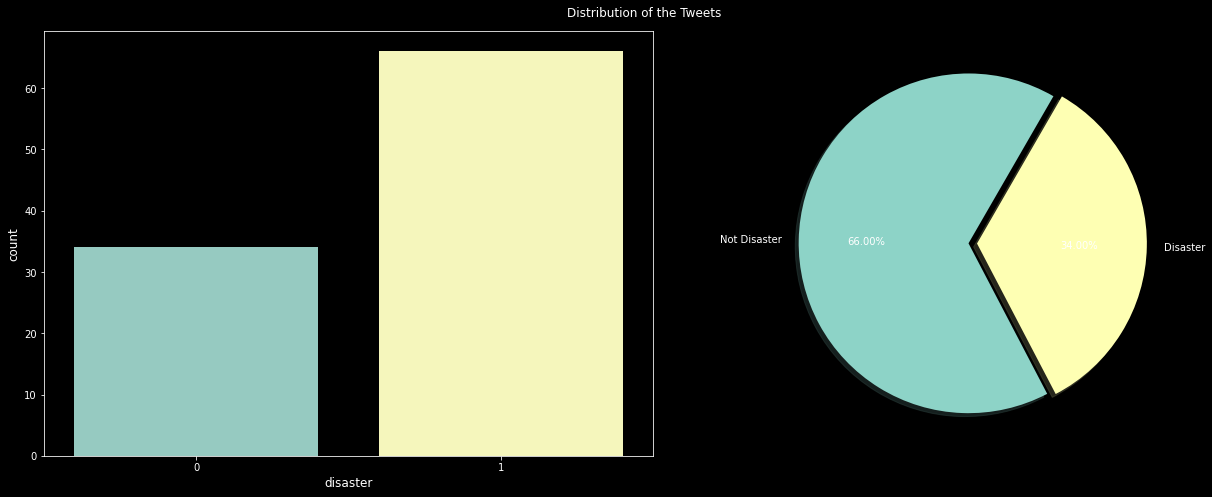

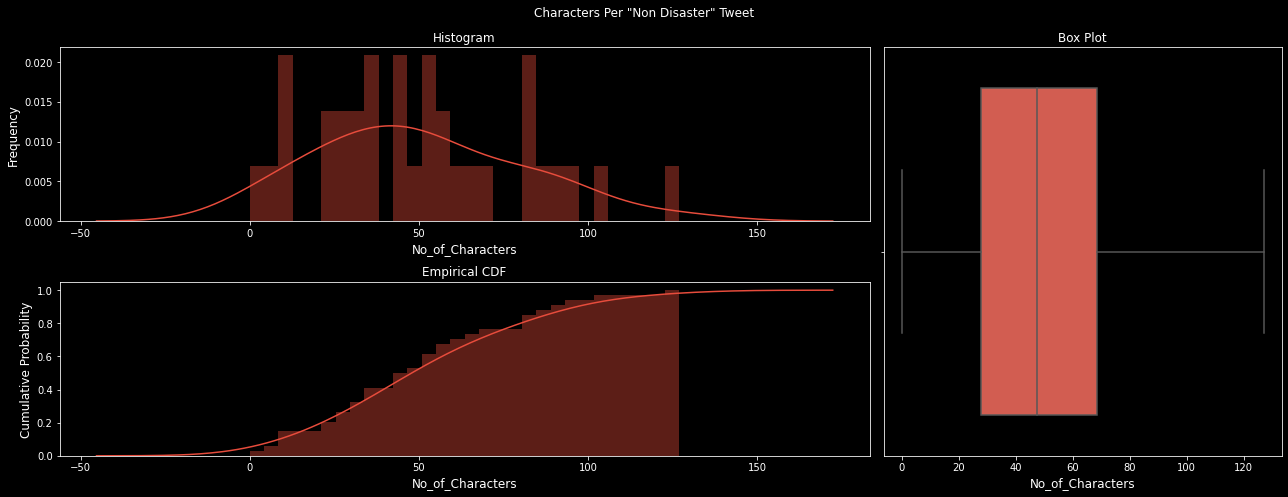

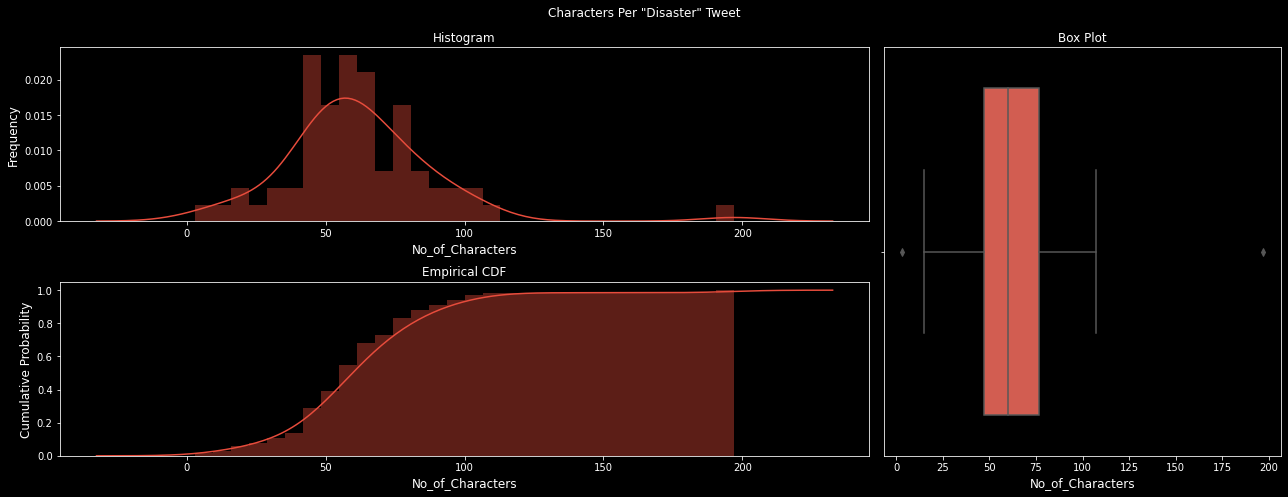

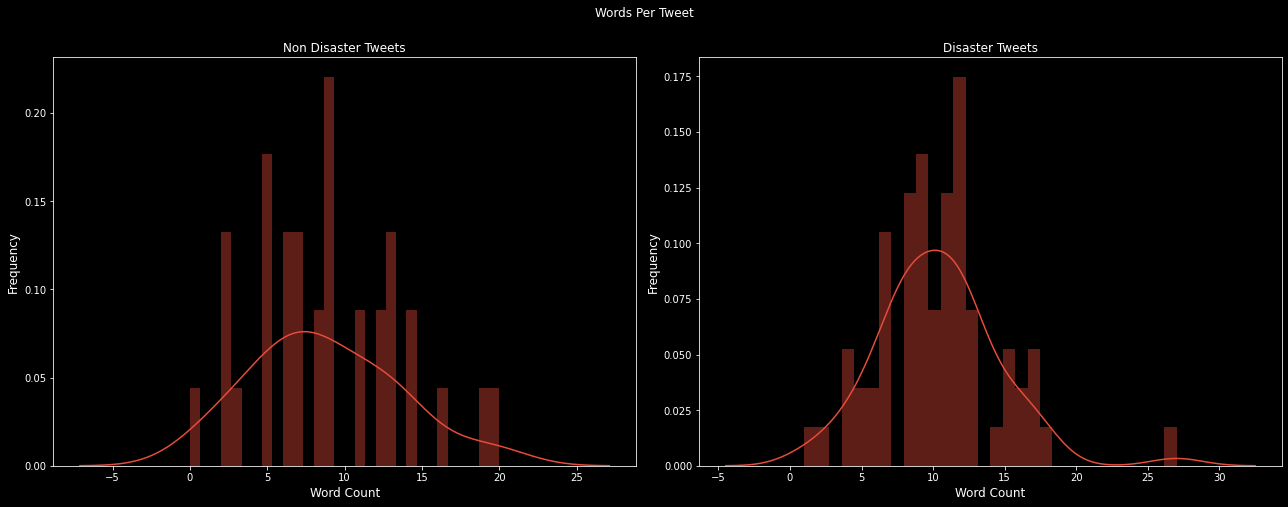

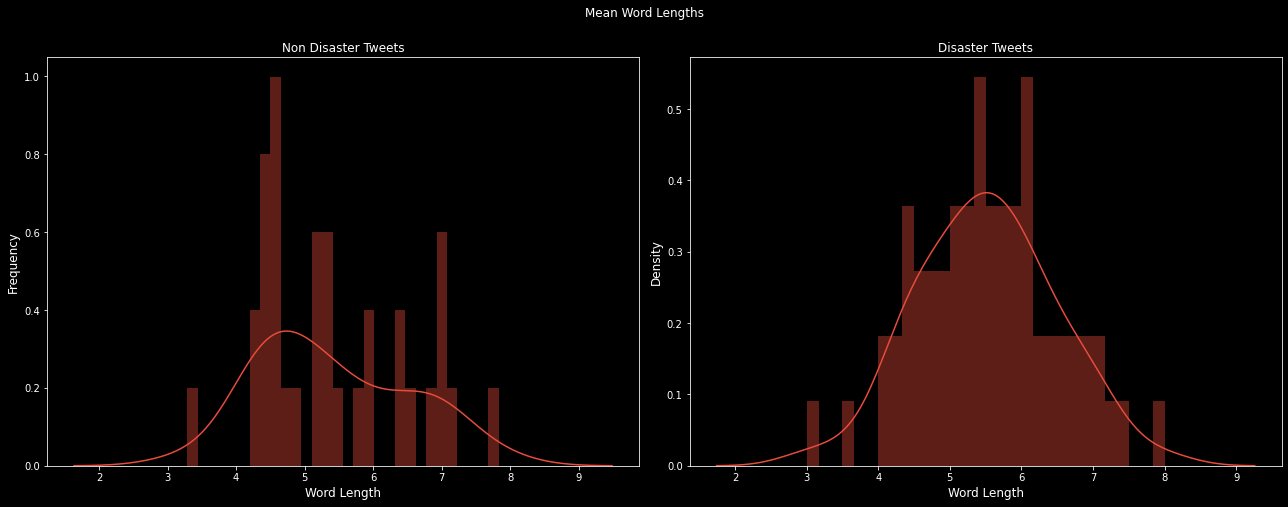

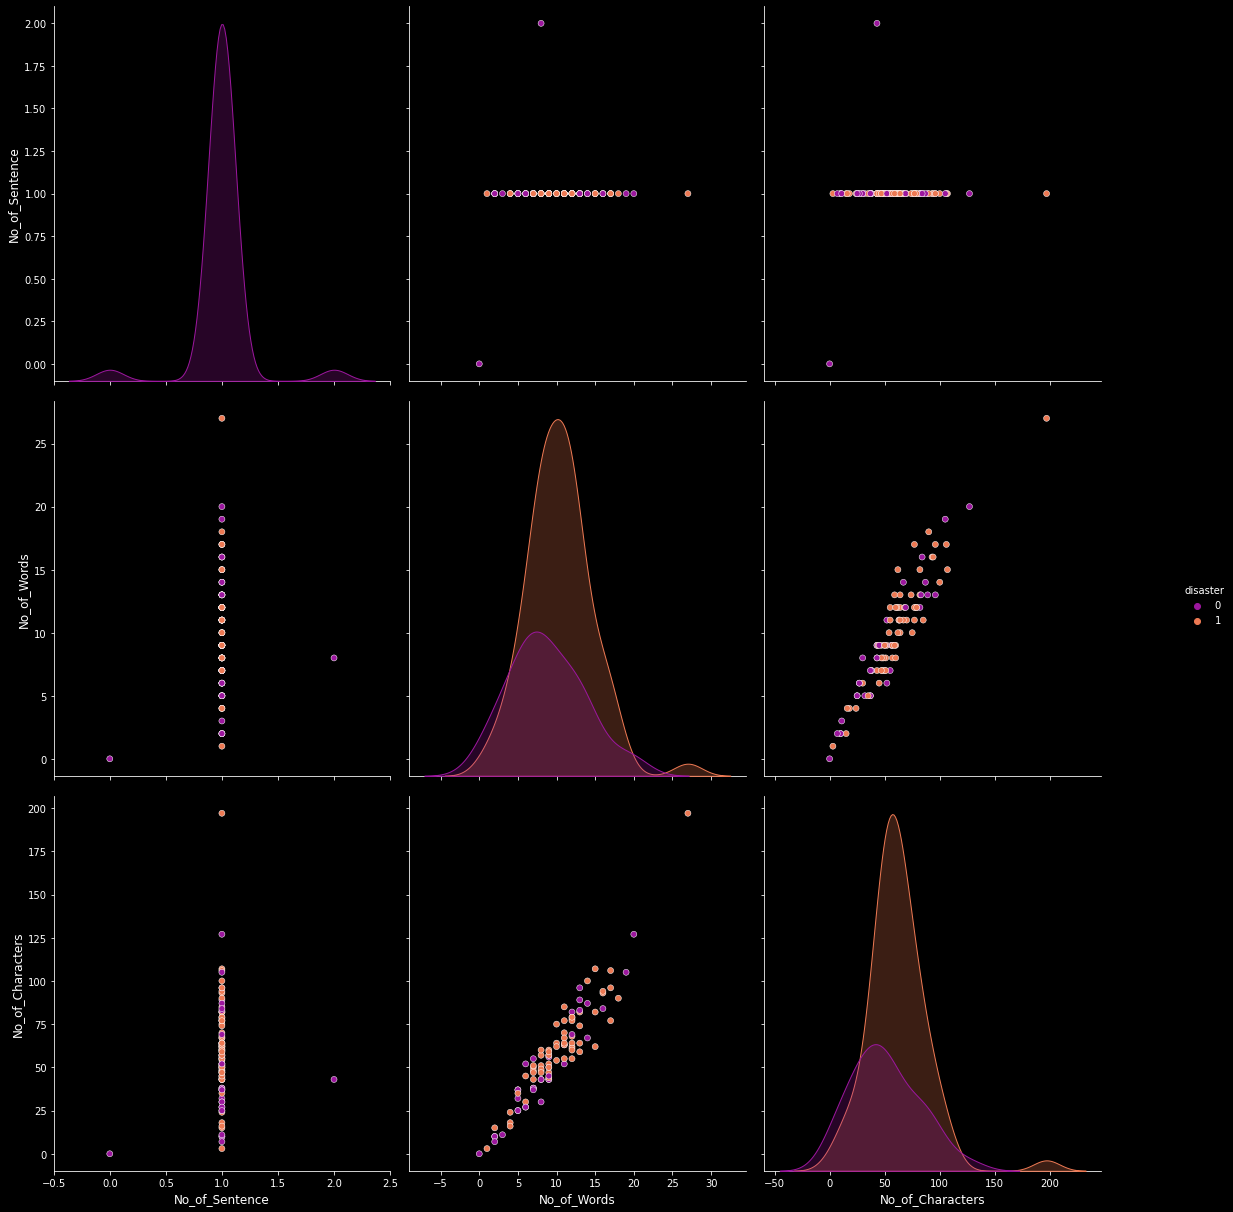

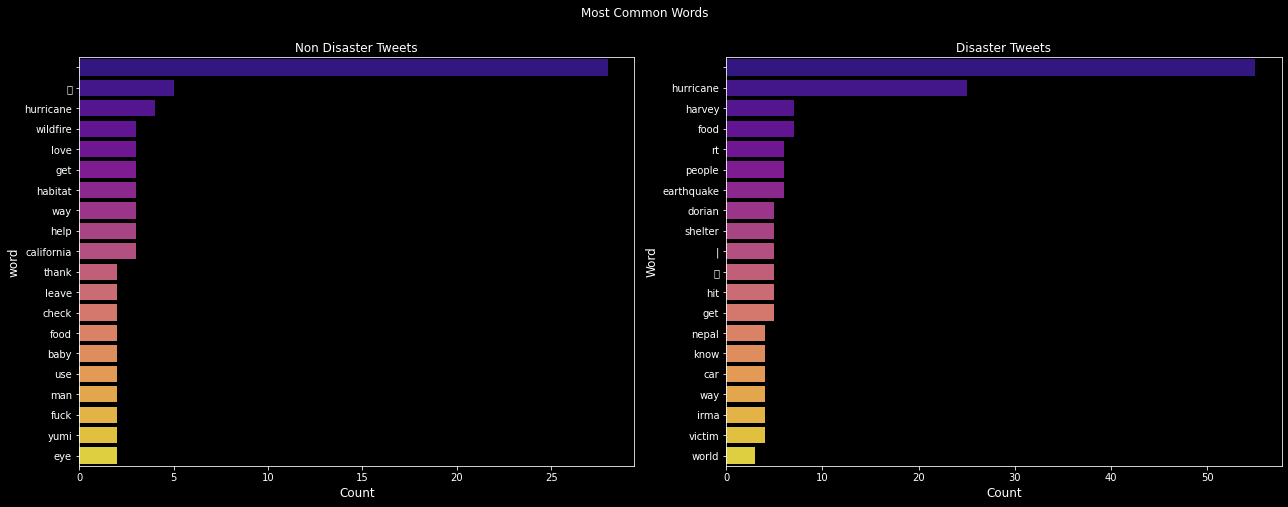

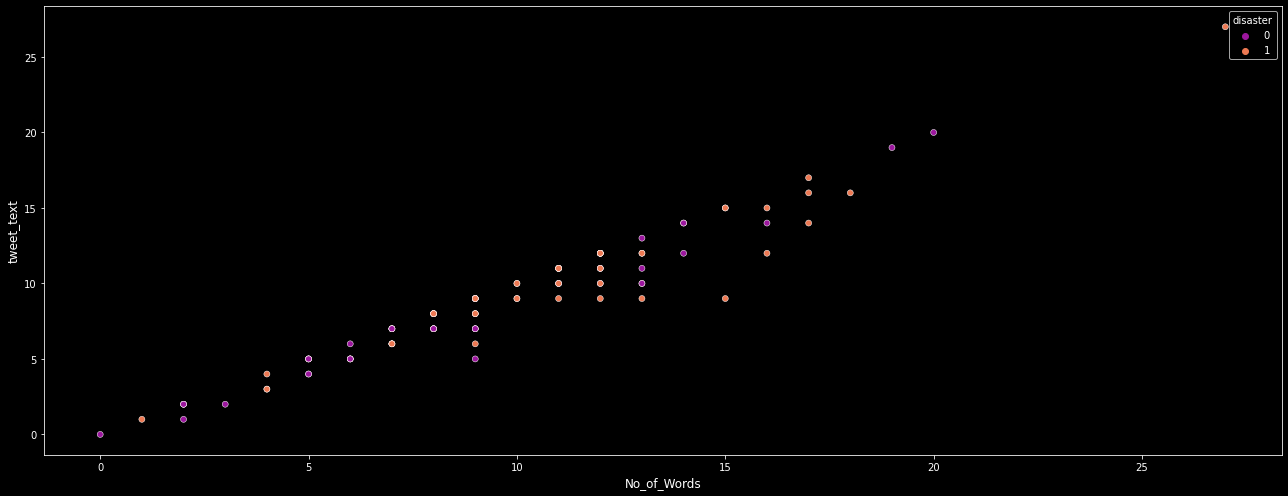

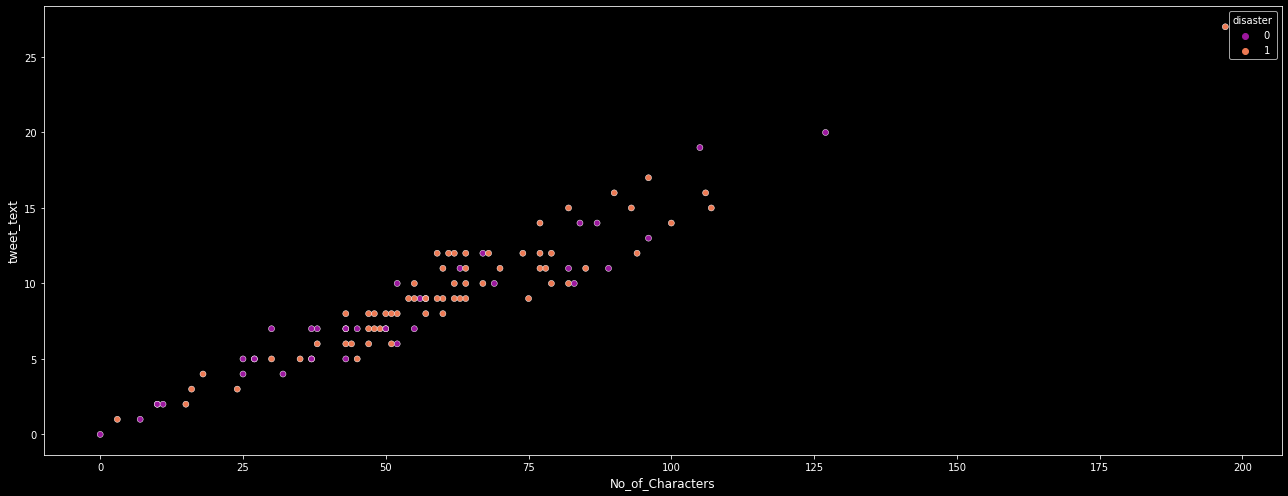

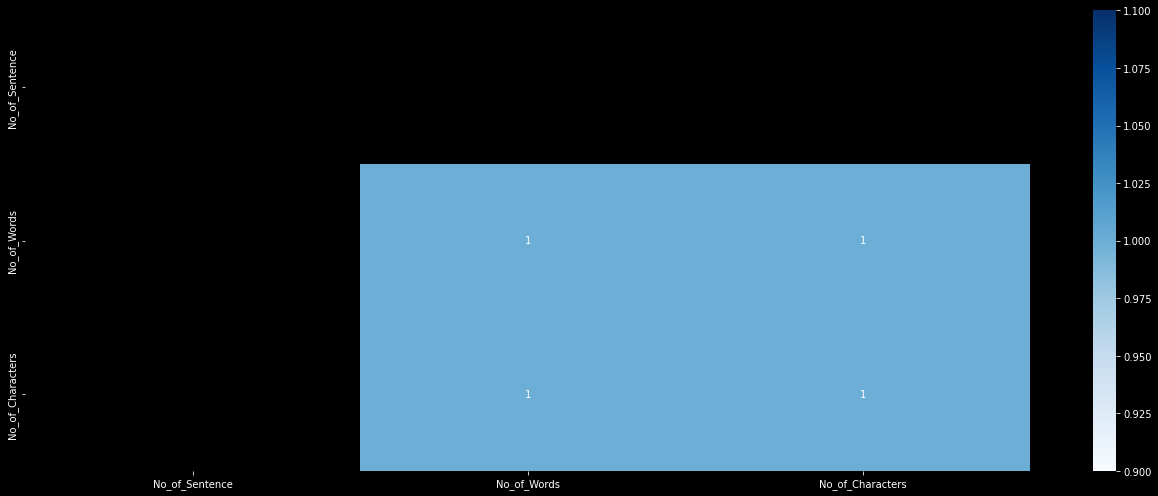

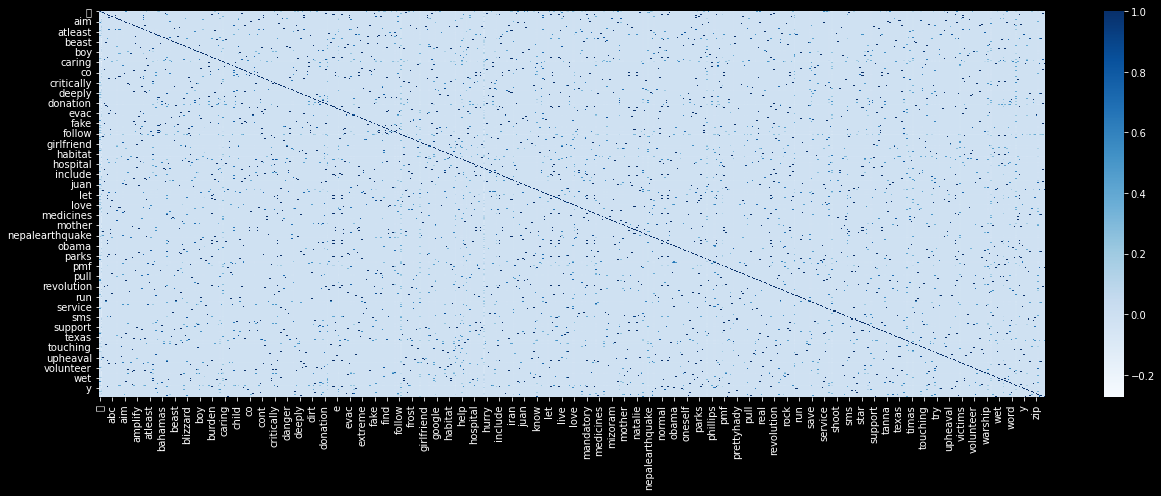

In [26]:
def word_cleanser(row):
    return re.sub(
        r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|[@#]\w+|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251]+|https?://\S+|www\.\S+",
        "",
        row,
    )


def word_initializer(row):
    token = [
        token.lemma_.strip()
        for token in nlp(word_cleanser(row))
        if not token.is_punct
        and not token.is_stop
        and not token.like_email
        and not token.like_num
        and not token.like_url
    ]
    return " ".join(t.lower().strip() for t in token) if token else "."


def word_tokenizer(row):
    token = [
        token.lemma_.strip()
        for token in nlp(word_cleanser(row))
        if not token.is_punct
        and not token.is_stop
        and not token.like_email
        and not token.like_num
        and not token.like_url
    ]
    return token if token else ["."]


def word_vectorizer(X_series):
    if NLP:
        return np.concatenate(
            [
                arr
                for arr in X_series.apply(
                    lambda row: nlp(" ".join(word_tokenizer(row.lower()))).vector
                    if NLP
                    else word_tokenizer(row.lower().strip()),
                )
            ]
        ).reshape(-1, 300)
    else:
        return X_series.apply(lambda row: " ".join(word_tokenizer(row.lower().strip()))).to_frame()


def tokenize_dataset(dataset):
    encoded = tokenizer(
        dataset,
        padding=True,
        truncation=True,
        return_tensors="np",
    )
    return encoded.data

        
def plot_target_pie():
    fig, axes = plt.subplots(ncols=2, nrows=1)
    sns.countplot(df_eda[y_label], ax=axes[0])
    axes[1].pie(
        df_eda[y_label].value_counts(),
        labels=["Not Disaster", "Disaster"],
        autopct="%1.2f%%",
        shadow=True,
        explode=(0.05, 0),
        startangle=60,
    )
    fig.suptitle("Distribution of the Tweets")
    plt.tight_layout()
    plt.show()


def plot_dist3(df_eda, feature, title):
    fig = plt.figure(constrained_layout=True)
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title("Histogram")
    sns.distplot(
        df_eda.loc[:, feature],
        hist=True,
        kde=True,
        ax=ax1,
        color="#e74c3c",
        bins=NUM_BINS,
    )
    ax1.set(ylabel="Frequency")

    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title("Empirical CDF")
    sns.distplot(
        df_eda.loc[:, feature],
        ax=ax2,
        kde_kws={"cumulative": True},
        hist_kws={"cumulative": True},
        color="#e74c3c",
        bins=NUM_BINS,
    )
    ax2.set(ylabel="Cumulative Probability")

    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title("Box Plot")
    sns.boxplot(x=feature, data=df_eda, orient="v", ax=ax3, color="#e74c3c")
    plt.suptitle(f"{title}")
    fig.tight_layout()


def plot_word_number_histogram(word_count_0, word_count_1):
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    sns.distplot(word_count_0, ax=axes[0], color="#e74c3c", bins=NUM_BINS)
    sns.distplot(word_count_1, ax=axes[1], color="#e74c3c", bins=NUM_BINS)

    axes[0].set_xlabel("Word Count")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Non Disaster Tweets")
    axes[1].set_xlabel("Word Count")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Disaster Tweets")

    fig.suptitle("Words Per Tweet", va="baseline")
    fig.tight_layout()


def plot_word_len_histogram(x_label0, x_label1):
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    sns.distplot(
        x_label0.str.split()
        .apply(lambda x: [len(i) for i in x])
        .map(lambda x: np.mean(x)),
        ax=axes[0],
        color="#e74c3c",
        bins=NUM_BINS,
    )
    sns.distplot(
        x_label1.str.split()
        .apply(lambda x: [len(i) for i in x])
        .map(lambda x: np.mean(x)),
        ax=axes[1],
        color="#e74c3c",
        bins=NUM_BINS,
    )

    axes[0].set_xlabel("Word Length")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Non Disaster Tweets")
    axes[1].set_xlabel("Word Length")
    axes[1].set_title("Disaster Tweets")

    fig.suptitle("Mean Word Lengths", va="baseline")
    fig.tight_layout()
    plt.show()


def plot_top_words():
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    top_words0 = (
        pd.Series(
            [
                word
                for tweet_tokens in df_eda[df_eda[y_label] == 0]["Tokens"]
                for word in tweet_tokens
            ]
        )
        .value_counts()
        .head(20)
    )
    top_words1 = (
        pd.Series(
            [
                word
                for tweet_tokens in df_eda[df_eda[y_label] == 1]["Tokens"]
                for word in tweet_tokens
            ]
        )
        .value_counts()
        .head(20)
    )
    sns.barplot(x=top_words0.values, y=top_words0.index, palette="plasma", ax=axes[0])
    sns.barplot(x=top_words1.values, y=top_words1.index, palette="plasma", ax=axes[1])
    axes[0].set_xlabel("Count")
    axes[0].set_ylabel("word")
    axes[0].set_title("Non Disaster Tweets")
    axes[1].set_xlabel("Count")
    axes[1].set_ylabel("Word")
    axes[1].set_title("Disaster Tweets")

    fig.suptitle("Most Common Words", va="baseline")
    fig.tight_layout()
    plt.show()


def plot_pairplot():
    g = sns.pairplot(data=df_eda, hue=y_label, palette="plasma")
    g.fig.set_size_inches(18, 18)
    plt.show()


def grey_color_func(
    word, font_size, position, orientation, random_state=None, **kwargs
):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


if len(col_cat_cv):
    import re
    import spacy

    nlp = spacy.load("en_core_web_lg", disable=["ner", "parser"])
    nlp.add_pipe("sentencizer")

    df_eda = df.sample(100, random_state=RANDOM_STATE)
#     df_eda = df.copy()
    df_eda[x_label] = df_eda[x_label].apply(word_initializer)

    df_eda["No_of_Sentence"] = df_eda[x_label].apply(
        lambda text: len(list(nlp(text).sents))
    )
    df_eda["No_of_Words"] = df_eda[x_label].apply(lambda text: len(nlp(text)))
    df_eda["No_of_Characters"] = df_eda[x_label].apply(len)
    df_eda["Tokens"] = df_eda[x_label].apply(
        lambda x: [token.text.lower() for token in nlp(x)]
    )
    label_corr = df_eda.groupby(y_label).mean().corr()
    token_corr = (
        df_eda["Tokens"]
        .apply(lambda tokens: pd.Series(tokens).value_counts(normalize=True))
        .fillna(0)
        .corr()
    )
    plot_target_pie()
    plot_dist3(
        df_eda[df_eda[y_label] == 0],
        "No_of_Characters",
        'Characters Per "Non Disaster" Tweet',
    )
    plot_dist3(
        df_eda[df_eda[y_label] == 1],
        "No_of_Characters",
        'Characters Per "Disaster" Tweet',
    )
    plot_word_number_histogram(
        df_eda[df_eda[y_label] == 0]["No_of_Words"],
        df_eda[df_eda[y_label] == 1]["No_of_Words"],
    )
    plot_word_len_histogram(
        df_eda[df_eda[y_label] == 0][x_label], df_eda[df_eda[y_label] == 1][x_label]
    )
    plot_pairplot()
    plot_top_words()
    visualization_functions = [
        lambda: sns.scatterplot(
            x=df_eda["No_of_Words"],
            y=df_eda[x_label].apply(lambda text: len(text.split())),
            hue=df_eda[y_label],
            palette="plasma",
        ),
        lambda: sns.scatterplot(
            x=df_eda["No_of_Characters"],
            y=df_eda[x_label].apply(lambda text: len(text.split())),
            hue=df_eda[y_label],
            palette="plasma",
        ),
        lambda: sns.heatmap(label_corr, annot=True, cmap="Blues"),
        lambda: sns.heatmap(token_corr, cmap="Blues"),
    ]

    for visualization_function in visualization_functions:
        visualization_function()
        plt.tight_layout()
        plt.show()

    nlp.remove_pipe("sentencizer")
    df_eda.drop(
        ["No_of_Characters", "No_of_Words", "No_of_Sentence", "Tokens"],
        axis=1,
        inplace=True,
    )


# Visualizing Wordcloud

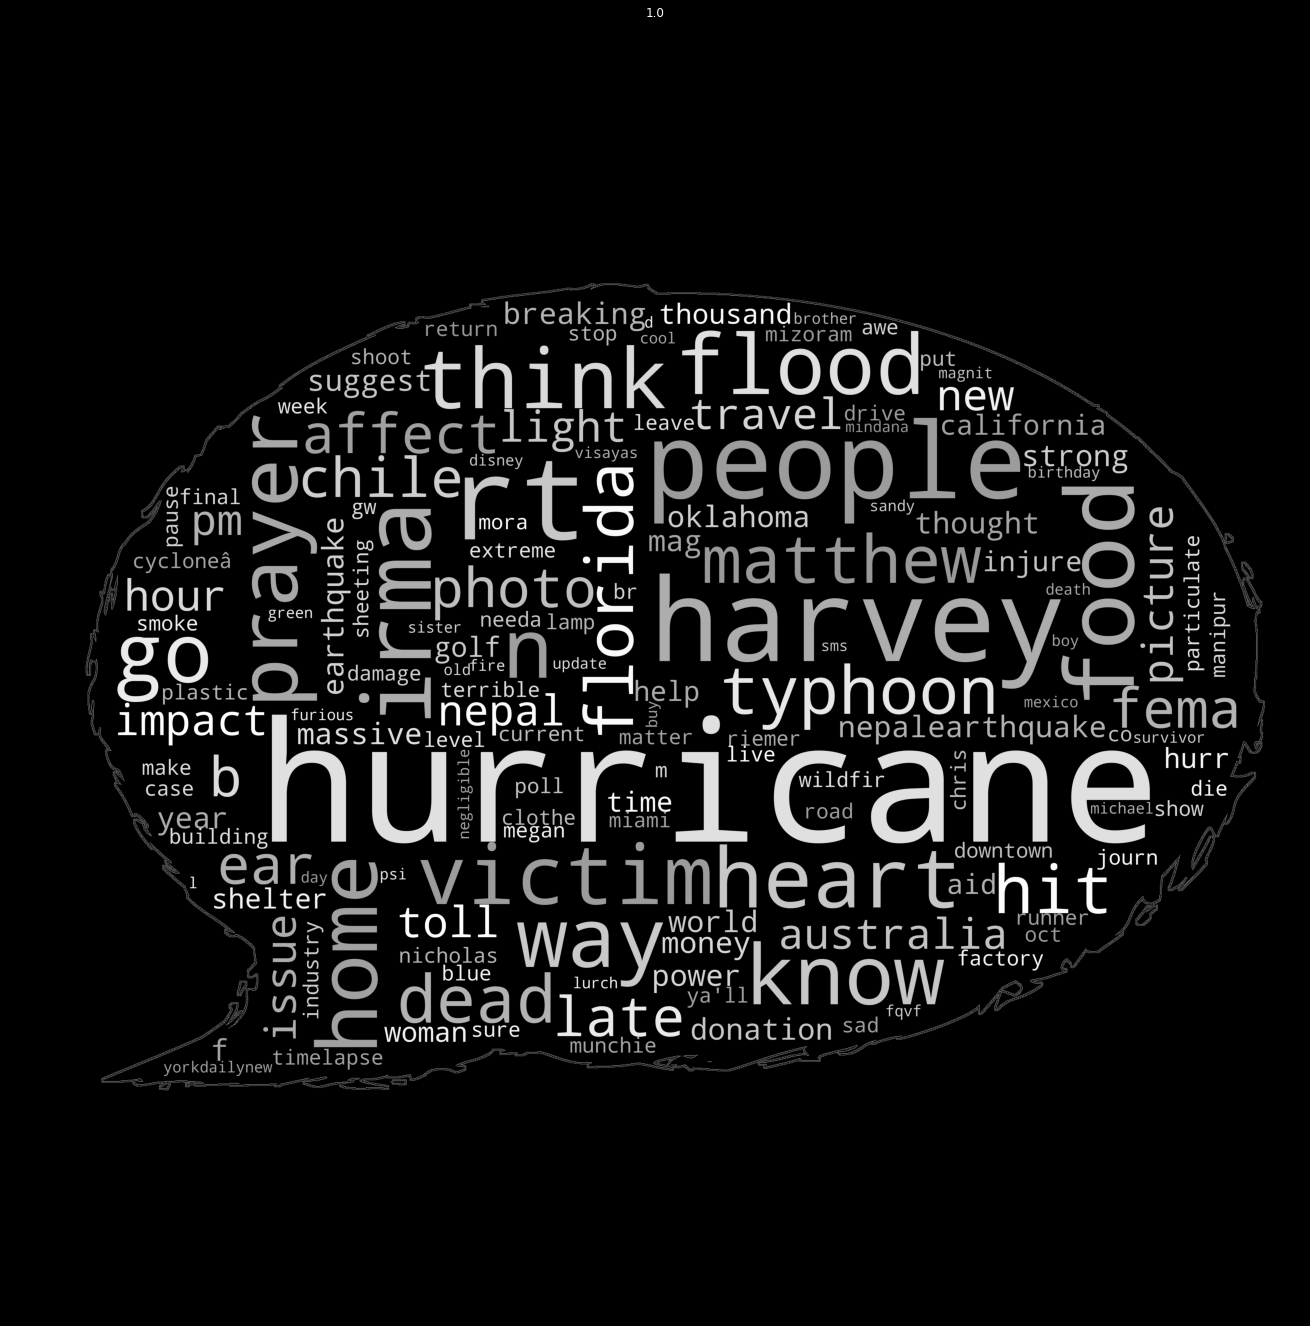

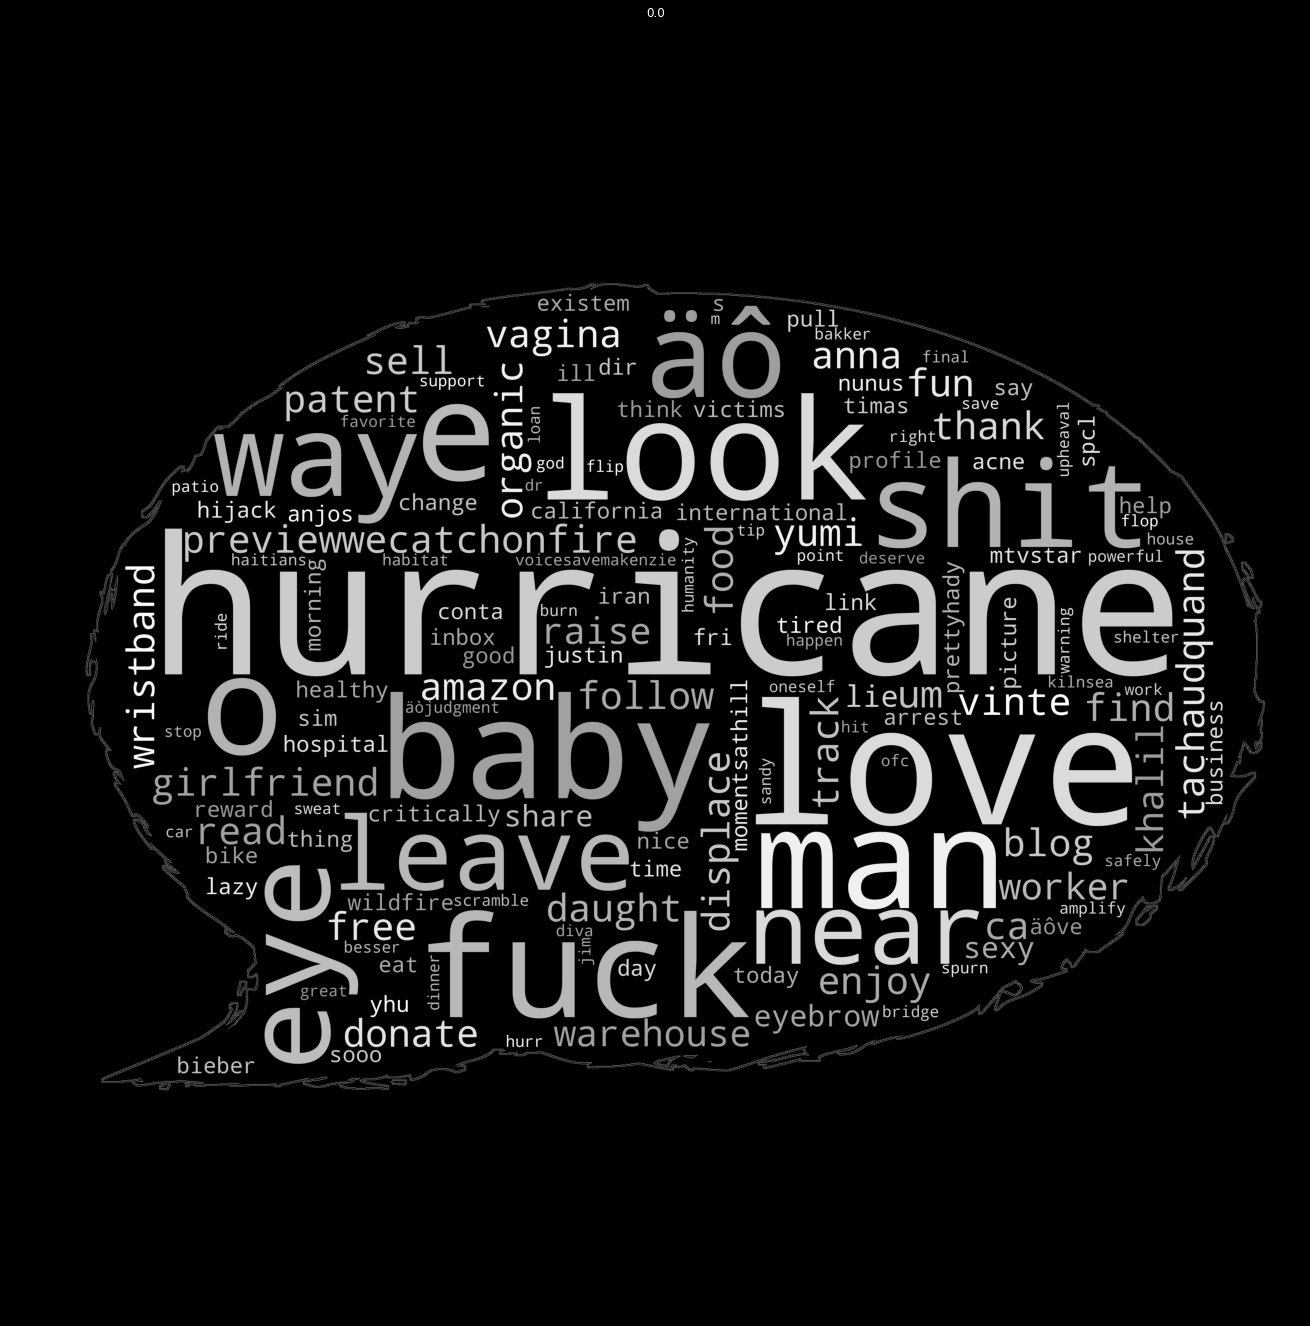

In [27]:
if len(col_cat_cv):
    from wordcloud import WordCloud

    mask = np.array(
        Image.open(
            BytesIO(
                requests.get(
                    "https://raw.githubusercontent.com/lyoh001/AzureML/main/mask.png"
                ).content
            )
        )
    )
    mask[mask.sum(axis=2) == 0] = 255

    for label in df_eda[y_label].unique():
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))
        wordcloud = WordCloud(
            width=1200,
            height=800,
            max_words=150,
            background_color="black",
            scale=3,
            mask=mask,
            contour_width=0.1,
            contour_color="grey",
            collocations=False,
        ).generate(str(df_eda[df_eda[y_label] == label][next(iter(col_cat_cv))]))
        plt.imshow(
            wordcloud.recolor(color_func=grey_color_func, random_state=42),
            interpolation="bilinear",
        )
        ax.axis("off")
        plt.tight_layout(pad=0)
        ax.imshow(wordcloud)
        ax.set_title(y_index[label])
        plt.show()


# Balancing the Sample Size

In [28]:
if DATA_BALANCE:
    df = df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
    min_sample_size = df[y_label].value_counts().min()
    df = pd.concat(
        [df[df[y_label] == val].sample(min_sample_size) for val in df[y_label].unique()],
        ignore_index=True,
    )
    print(df[y_label].value_counts())

1    1680
0    1680
Name: disaster, dtype: int64


# Feature Engineering and Data Pipeline (Impute, OHE, Scaling, Variance Threshold, PCA)

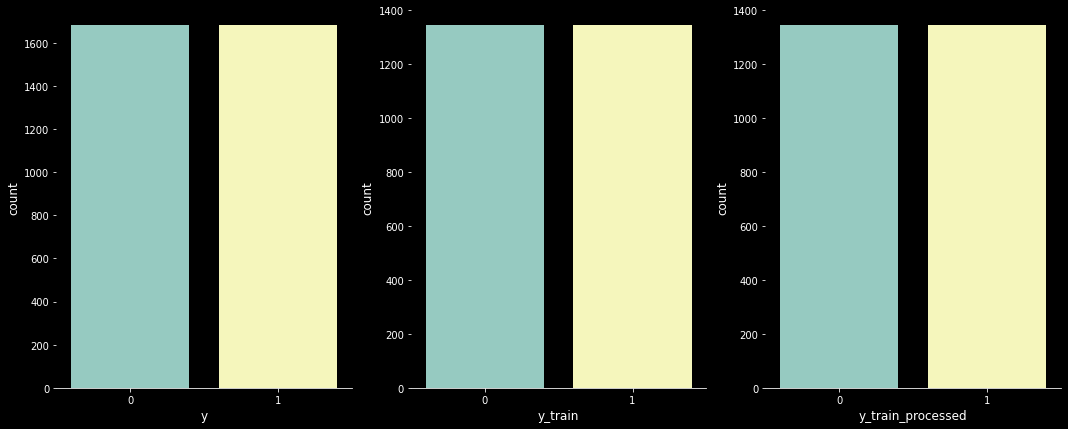

-------------------------------------------------------
class_weights: {0: 1.0, 1: 1.0}
-------------------------------------------------------
y:
1   0.50
0   0.50
Name: disaster, dtype: float64
-------------------------------------------------------
y_train:
1   0.50
0   0.50
Name: disaster, dtype: float64
-------------------------------------------------------
y_train_processed:
1   0.50
0   0.50
Name: disaster, dtype: float64
-------------------------------------------------------
y_test:
1   0.50
0   0.50
Name: disaster, dtype: float64
-------------------------------------------------------
y_test_processed:
1   0.50
0   0.50
Name: disaster, dtype: float64
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (0): []
col_num_disc (0): []
col_num_cont (0): []
-------------------------------------------------------
total cols for preprocessor: 0
-------------------------------------------------------
X: (3360, 1)	X_train: (2688, 1)	X_train_processed:

In [29]:
%%time
X, y = df.drop(y_label, axis=1), df[y_label]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
preprocessor_cat_ohe = make_pipeline(
    (SimpleImputer(strategy="constant", fill_value="missing")),
    (OneHotEncoder(handle_unknown="ignore", sparse=False)),
)
preprocessor_cat_cv = make_pipeline(
    [
        (FunctionTransformer(word_vectorizer)),
        (FunctionTransformer(word_vectorizer)),
        (TfidfVectorizer(tokenizer=word_tokenizer, ngram_range=[1, 1])),
        (CountVectorizer(tokenizer=word_tokenizer, ngram_range=[1, 1])),
    ][NLP]
)
preprocessor_num_disc = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_num_cont = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_col = make_column_transformer(
    (preprocessor_cat_oe, col_cat_oe),
    (preprocessor_cat_ohe, col_cat_ohe),
    (preprocessor_cat_cv, next(iter(col_cat_cv)) if len(col_cat_cv) else []),
    (preprocessor_num_disc, col_num_disc),
    (preprocessor_num_cont, col_num_cont),
    sparse_threshold=0
)
preprocessor = make_pipeline(
    (preprocessor_col),
#     ([MinMaxScaler(), StandardScaler()][SCALER]),
#     (VarianceThreshold(threshold=0)),
#     (PCA())
)
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
if CLASSIFICATION:
    class_weights = {i: w for i, w in enumerate(class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_processed), y=y_train_processed))}
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0]).set_xlabel("y")
    sns.countplot(y_train, ax=ax[1]).set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2]).set_xlabel("y_train_processed")
    plt.show()
    print("-------------------------------------------------------")
    print(f"class_weights: {class_weights}")
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")
if not NLP:
    tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
    X_train_processed, X_test_processed = tokenize_dataset(X_train_processed.reshape(1, -1).tolist()[0]), tokenize_dataset(X_test_processed.reshape(1, -1).tolist()[0])

# Building, Hyper-param Tuning ML and ANN Models

In [30]:
def tune_dl_model(hp):
    if NLP:
        model = keras.models.Sequential()
        model.add(
            keras.layers.Dense(
                units=hp.Int("input_00_unit", min_value=32, max_value=512, step=32),
                input_shape=X_train_processed.shape[1:],
            )
        )
        for i in range(hp.Int("num_layers", min_value=1, max_value=64)):
            model.add(
                keras.layers.Dense(
                    units=hp.Int(
                        f"hidden_{i:02}_unit", min_value=32, max_value=512, step=32
                    ),
                    activation="relu",
                )
            )
            model.add(
                keras.layers.Dropout(
                    hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)
                )
            )
        model.add(
            keras.layers.Dense(
                units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
                activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
            )
        )
    else:
        model = TFAutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=2)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])
        ),
        loss=[
            "mean_squared_error",
            "binary_crossentropy",
            "sparse_categorical_crossentropy",
        ][CLASSIFICATION] if NLP else keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model


def train_dl_model():
    tuner.search(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        callbacks=[early_stop],
        epochs=MAX_TRIALS,
        validation_split=0.2,
        verbose=1,
    )
    tuner.results_summary()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None,
    )
    val_per_epoch = history.history[
        ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
    ]
    best_epoch = (
        val_per_epoch.index(
            [min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]
        )
        + 1
    )

    plt.subplot(1, 2, 1)
    sns.lineplot(
        data=history.history[
            ["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]
        ],
        color="deeppink",
        linewidth=2.5,
    )
    sns.lineplot(
        data=history.history[
            ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
        ],
        color="darkturquoise",
        linewidth=2.5,
    )
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
    plt.grid()

    plt.subplot(1, 2, 2)
    sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_loss"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Loss", "Val Loss"], loc="upper right")
    plt.grid()
    plt.show()

    print(f"Best epoch: {best_epoch}")

    return best_epoch, best_hps


def build_dl_model(best_epoch, best_hps):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=best_epoch,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None,
    )
    print("-------------------------------------------------------")
    classification_report_test = classification_report(
        y_test_processed,
        np.argmax(model.predict(X_test_processed), axis=1)
        if CLASSIFICATION - 1
        else model.predict(X_test_processed).round()
        if NLP
        else tf.argmax(
            tf.nn.softmax(model.predict(X_test_processed).logits, axis=1), axis=1
        ).numpy(),
        output_dict=True,
    )
    print(
        f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)"
    )
    classification_report_train = classification_report(
        y_train_processed,
        np.argmax(model.predict(X_train_processed), axis=1)
        if CLASSIFICATION - 1
        else model.predict(X_train_processed).round()
        if NLP
        else tf.argmax(
            tf.nn.softmax(model.predict(X_train_processed).logits, axis=1), axis=1
        ).numpy(),
        output_dict=True,
    )
    print(
        f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)"
    )
    print("-------------------------------------------------------")
    print(
        classification_report(
            y_test_processed,
            np.argmax(model.predict(X_test_processed), axis=1)
            if CLASSIFICATION - 1
            else model.predict(X_test_processed).round()
            if NLP
            else tf.argmax(
                tf.nn.softmax(model.predict(X_test_processed).logits, axis=1), axis=1
            ).numpy(),
        )
    )
    sns.heatmap(
        tf.math.confusion_matrix(
            y_test_processed,
            np.argmax(model.predict(X_test_processed), axis=1)
            if CLASSIFICATION - 1
            else model.predict(X_test_processed).round()
            if NLP
            else tf.argmax(
                tf.nn.softmax(model.predict(X_test_processed).logits, axis=1), axis=1
            ).numpy(),
        ),
        cmap="Blues",
        fmt="d",
        annot=True,
        linewidths=1,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    
    return model


if SEARCH == "hyperband":
    tuner = Hyperband(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][
            CLASSIFICATION
        ],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][
            CLASSIFICATION
        ],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][
            CLASSIFICATION
        ],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=int(MAX_TRIALS / 4)
)
tuner.search_space_summary()


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


# Building Neural Network Model

Trial 4 Complete [00h 00m 33s]
val_accuracy: 0.8104089498519897

Best val_accuracy So Far: 0.845724880695343
Total elapsed time: 00h 02m 31s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.845724880695343
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8104089498519897
Trial summary
Hyperparameters:
learning_rate: 1e-05
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7936803102493286
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.5148698687553406


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
9/9 [==============================] - 15s 830ms/step - loss: 0.5868 - accuracy: 0.6963 - val_loss: 0.4837 - val_accuracy: 0.7937
Epoch 2/10
9/9 [==============================] - 6s 667ms/step - loss: 0.4003 - accuracy: 0.8442 - val_loss: 0.4431 - val_accuracy: 0.8309
Epoch 3/10
9/9 [==============================] - 6s 657ms/step - loss: 0.2926 - accuracy: 0.8884 - val_loss: 0.4405 - val_accuracy: 0.8141
Epoch 4/10
9/9 [==============================] - 6s 654ms/step - loss: 0.2412 - accuracy: 0.9079 - val_loss: 0.3833 - val_accuracy: 0.8476
Epoch 5/10
9/9 [==============================] - 6s 654ms/step - loss: 0.1845 - accuracy: 0.9284 - val_loss: 0.3992 - val_accuracy: 0.8476
Epoch 6/10
9/9 [==============================] - 6s 657ms/step - loss: 0.1364 - accuracy: 0.9502 - val_loss: 0.4573 - val_accuracy: 0.8550
Epoch 7/10
9/9 [==============================] - 6s 661ms/step - loss: 0.0812 - accuracy: 0.9758 - val_loss: 0.4287 - val_accuracy: 0.8662
Epoch 8/10
9/9 [===

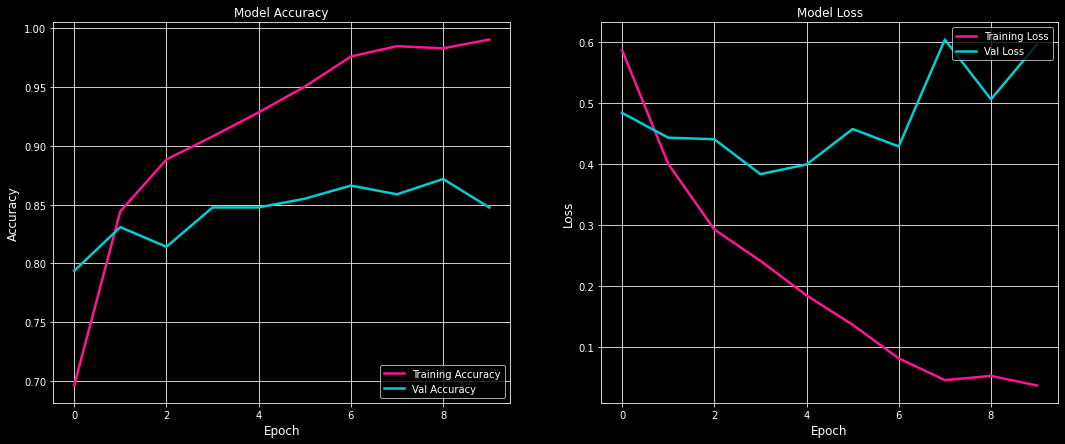

Best epoch: 9


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/9
9/9 [==============================] - 15s 906ms/step - loss: 0.5627 - accuracy: 0.7409 - val_loss: 0.4629 - val_accuracy: 0.8160
Epoch 2/9
9/9 [==============================] - 6s 656ms/step - loss: 0.3751 - accuracy: 0.8586 - val_loss: 0.3914 - val_accuracy: 0.8401
Epoch 3/9
9/9 [==============================] - 6s 657ms/step - loss: 0.2819 - accuracy: 0.8884 - val_loss: 0.4064 - val_accuracy: 0.8234
Epoch 4/9
9/9 [==============================] - 6s 654ms/step - loss: 0.2249 - accuracy: 0.9135 - val_loss: 0.3738 - val_accuracy: 0.8457
Epoch 5/9
9/9 [==============================] - 6s 654ms/step - loss: 0.1334 - accuracy: 0.9567 - val_loss: 0.4993 - val_accuracy: 0.8383
Epoch 6/9
9/9 [==============================] - 6s 656ms/step - loss: 0.0906 - accuracy: 0.9688 - val_loss: 0.4747 - val_accuracy: 0.8550
Epoch 7/9
9/9 [==============================] - 6s 655ms/step - loss: 0.0560 - accuracy: 0.9828 - val_loss: 0.4943 - val_accuracy: 0.8717
Epoch 8/9
9/9 [===========

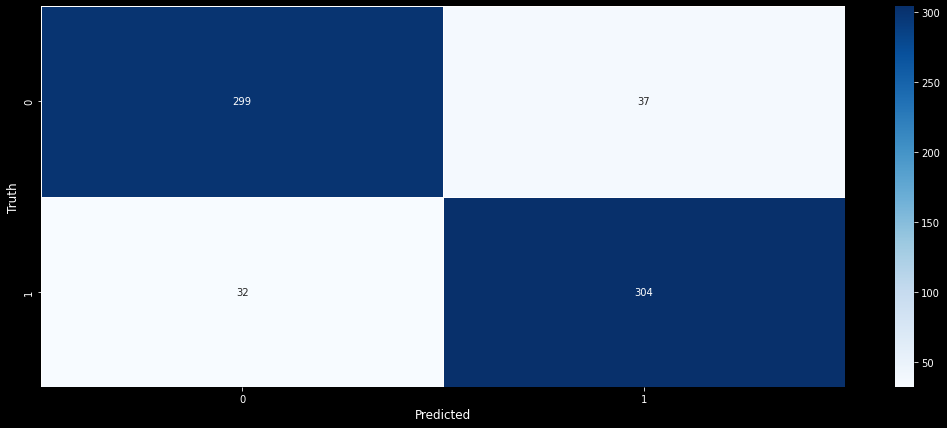

In [31]:
%%time
OVERSAMPLE = 0
dl_model = build_dl_model(*train_dl_model())

# Saving the Model for Deployment

In [32]:
dl_model.save(f"dl_model_{time_stamp}") if NLP else dl_model.save_pretrained(
    f"dl_model_{time_stamp}"
)
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
dump(preprocessor, open(f"preprocessor.pkl", "wb"))
dl_model.summary()
plot_model(dl_model, show_shapes=True)